In [1]:
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from keras.layers import LSTM
from keras.layers import Embedding
from keras.optimizers import RMSprop


from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.utils import np_utils

from sklearn.metrics import accuracy_score
from keras.layers import Concatenate, Merge

import keras
from keras.utils import to_categorical

from matplotlib import pyplot as plt
from IPython.display import clear_output

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [82]:
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="accuracy")
        ax2.plot(self.x, self.val_acc, label="validation accuracy")
        ax2.legend()
        
        plt.show();
        print("val_loss: ", logs.get('val_loss'))
        print("val_acc: ", logs.get('val_acc'))
        print("loss: ", logs.get('loss'));
        print("acc: ", logs.get('acc'))
        
plot = PlotLearning()

In [11]:
y = np.load("y.npy")
X = np.load("X.npy")

In [12]:
test_size = 500

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

In [50]:
y_train.shape

(1301,)

In [51]:
X_notes = X_train.T[:28].T
X_notes = np.vstack((X_notes, X_test.T[:28].T))
y_notes = y_train
y_notes = np.append(y_notes, y_test)
X_chords = X_train.T[28:].T
X_chords = np.vstack((X_chords, X_test.T[28:].T))

In [52]:
X_chords.shape

(1801, 28)

In [53]:
X_chords = np.column_stack((X_chords, y_notes.T))
X_chords = X_chords.reshape((-1,1))

In [54]:
chords = np.unique(X_chords)
len(chords)

29

In [55]:
chords_y = np.unique(y)

In [56]:
chords_y

array(['a', 'ad', 'am', 'b', 'bb', 'bm', 'c', 'c#', 'c#d', 'c#m', 'cm',
       'd', 'dm', 'e', 'eb', 'em', 'f', 'f#', 'f#m', 'g', 'gd', 'gm'],
      dtype='<U32')

In [57]:
coded_y = np.array([])

for note in y_notes:
    for i, chord in enumerate(chords):
        if note == chord:
            coded_y = np.append(coded_y, i)

            
            

In [58]:
coded_X_chords = np.array([])

for x_chord in X_chords:
    for i, chord in enumerate(chords):
        if x_chord == chord:
            coded_X_chords = np.append(coded_X_chords, i)

            
            

In [59]:
X_chords = coded_X_chords.reshape((1801,-1))
y_notes = coded_y

In [65]:
np.unique(X_notes)

array(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype='<U32')

In [66]:
X_1 = X_chords[:-test_size]
X_1_test = X_chords[-test_size:]

In [67]:
X_2 = X_notes[:-test_size]
X_2_test = X_notes[-test_size:]

In [68]:
y = y_notes[:-test_size]
y_test = y_notes[-test_size:]

In [69]:
X_1.shape

(1301, 29)

In [70]:
X_2.shape

(1301, 28)

In [71]:
model_1 = Sequential()
model_1.add(Embedding(29, 20, input_length=29))
model_1.add(LSTM(20))
#model.add(Dense(37, activation='softmax'))
#model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#model.fit(train_X, train_y, epochs=1, batch_size=1, verbose=1, validation_data=(test_X, test_y))#, callbacks=[plot]);

In [72]:
model_2 = Sequential()
model_2.add(Embedding(13, 20, input_length=28))
model_2.add(LSTM(20))
#model.add(Dense(17, activation='softmax'))
#model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
#model.fit(X_train_2, y_train_2, epochs=60, verbose=1, validation_data=(X_test_2, y_test_2), callbacks=[plot]);

In [73]:
X_2 = np.array(X_2)

In [74]:
print(X_2.shape)
print(X_1.shape)

(1301, 28)
(1301, 29)


In [75]:
np.unique(y)

array([ 0.,  2.,  3.,  4.,  5.,  6.,  7.,  9., 10., 11., 12., 14., 15.,
       16., 19., 20., 21., 22., 24., 27., 28.])

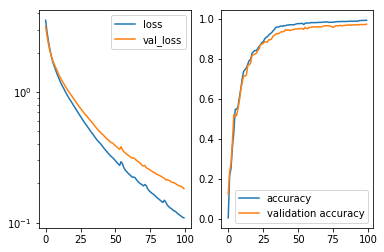

val_loss:  0.18205484449863435
val_acc:  0.9720000267028809
loss:  0.10867455849663099
acc:  0.9915449734745715


In [83]:
merged_model = Sequential()
merged_model.add(Merge([model_1, model_2], mode="concat"))
merged_model.add(Dense(29, activation='softmax'))
merged_model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
merged_model.fit([X_1, X_2], y, batch_size=100, epochs=100, verbose=1, callbacks=[plot], validation_data=[[X_1_test, X_2_test], y_test])